In [1]:
import torch
from matplotlib import pyplot as plt

In [16]:
import numpy as np

def normalize(x:dict):
    x['EEG_Raw'] = (x['EEG_Raw'] - x['EEG_Raw'].mean(axis=-1, keepdims=True)) / (x['EEG_Raw'].std(axis=-1, keepdims=True) + 1e-6)
    return x

def crop(x:dict,time=10):
    start = np.random.randint(0, x['EEG_Raw'].shape[1] - 256*time)
    end = start + 256*time
    x['EEG_Raw'] = x['EEG_Raw'][11:12, start:end]
    x['Age'] = (x['Age']*0.01).astype(np.float32)
    return x

def encode_label(x:dict):
    x['ComorbidityLevelDesc'] = (x['ComorbidityLevelDesc']).astype(np.float32)
    return x

def composer(*funcs):
    def compose(x):
        for f in funcs:
            x = f(x)
        return x
    return compose

In [3]:
import torch.nn as nn
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer


# 1D Convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ConvEncoder(nn.Module):
    def __init__(self, in_channels, kernel_size:list, embeding_size:int):
        super(ConvEncoder, self).__init__()
        self.conv_block = []
        for i in range(len(kernel_size)):
            self.conv_block.append(ConvBlock(in_channels, embeding_size, kernel_size[i], (kernel_size[i]+1)//2,  (kernel_size[i]-1)//2))
            in_channels = embeding_size
        self.conv_block = nn.Sequential(*self.conv_block)

    def forward(self, x):
        return self.conv_block(x)
    
class EEGTransformerEncoder(nn.Module):

    def __init__(self, in_channels=1, kernel_size=[3,3,3], embeding_size=32, num_layers=4, num_heads=8, hidden_size=64, dropout=0.1):
        super(EEGTransformerEncoder, self).__init__()
        self.conv_encoder = ConvEncoder(in_channels, kernel_size, embeding_size )
        encoder_layers = TransformerEncoderLayer(d_model=embeding_size, nhead=num_heads, dropout=0.1, dim_feedforward=hidden_size, batch_first=True, activation='gelu')
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        #self.positional_encoding = PositionalEncoding(embeding_size, max_len=256,dropout=0)

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.permute(0, 2, 1) # (batch, dim, time) -> (batch, time, dim)
        #x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        return x

In [36]:
from backbone import EEGTransformerEncoder
import torch.nn as nn

class supervised_baseline(nn.Module):
    def __init__(self, in_channels = 1,embeding_size=32, conv_kernel_size = [3,3,3], hidden_size=64, num_layers=4, num_heads=8, dropout=0.1):
        super().__init__()
        self.encoder = EEGTransformerEncoder(in_channels=in_channels, kernel_size=conv_kernel_size, embeding_size=embeding_size, num_layers=num_layers, num_heads=num_heads, hidden_size=hidden_size, dropout=dropout)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(embeding_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        x = self.encoder(x) #(batch, time, dim)
        x = x.mean(dim=1)
        x = self.regressor(x)
        return x

In [17]:
from miscellaneous.dataloader import FHA_Supervised
from torch.utils.data import DataLoader

preprocess = composer(crop, normalize, encode_label )
dataset_train = FHA_Supervised(r"D:\EEG\FHA\Resting\001_a01_01", r"Annotations\Surrey_Chunks.csv", r".hdf5",fileType='hd5', dataset_path=r"clips", keys=['EEG_Raw'], labels=[ 'Age','ComorbidityLevelDesc'], preprocessor = preprocess,validation=False,filter='Age > 18')

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False, num_workers=0)

In [18]:
preprocess = composer(crop,normalize,encode_label )
dataset_eval = FHA_Supervised(r"D:\EEG\FHA\Resting\001_a01_01", r"Annotations\Burnaby_Chunks.csv", r".hdf5",fileType='hd5', dataset_path=r"clips", keys=['EEG_Raw'], labels=[ 'Age','ComorbidityLevelDesc'], preprocessor = preprocess,validation=False,filter=' Age > 18')

dataloader_eval = DataLoader(dataset_eval, batch_size=64, shuffle=False, num_workers=0)

In [7]:
model = supervised_baseline(in_channels=1,embeding_size=32, conv_kernel_size = [5,3,3], hidden_size=32, dropout=0.1, num_layers=2, num_heads=8)

#count model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 20609


## Age

In [35]:
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()

    def forward(self, y_pred, y_true):
        #R2 score
        r2 = 1 - ((y_pred - y_true) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum()
        r2 = torch.clamp(r2, min=0.0, max=1.0)  # Ensure r2 is between 0 and 1

        #mse loss
        mse_loss = nn.MSELoss()(y_pred, y_true)
        return mse_loss*0.5 + (1 - r2) * 0.5  # Combine MSE loss and R2 score

def train(model, dataloader, optimizer, criterion, epoch):
    model.train()
    model.cuda()
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        x = batch['EEG_Raw'].cuda()
        y = batch['Age'].cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output.ravel(), y.ravel())
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')
    
@torch.no_grad()
def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    predictions = []
    targets = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            x = batch['EEG_Raw'].cuda()
            y = batch['Age'].cuda()
            output = model(x)
            loss = criterion(output.ravel(), y.ravel())
            running_loss += loss.detach().item()
            predictions.append(output.cpu().numpy())
            targets.append(y.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0).ravel()
    targets = np.concatenate(targets, axis=0)
    epoch_loss = running_loss / len(dataloader)
    
    # Calculate R2 score
    r2 = 1 - ((predictions - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
    print(f'Test Loss: {epoch_loss:.4f}')
    print(f'R2 Score: {r2:.4f}')

def main(model, optimizer, num_epochs):
    criterion = nn.MSELoss()
    model = model.cuda()
    for epoch in range(num_epochs):
        train(model, dataloader_train, optimizer, criterion, epoch)
        test(model, dataloader_eval, criterion)
        print('-----------------------------------')

## Classification

In [22]:
def encode_label(x:dict):
    x = (x['ComorbidityLevelDesc'] > 0).float()
    return x

def train(model, dataloader, optimizer, criterion, epoch):
    model.train()
    model.cuda()
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        x = batch['EEG_Raw'].cuda()
        y = encode_label(batch).cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output.ravel(), y.ravel())
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')

    return epoch_loss

@torch.no_grad()
def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    predictions = []
    targets = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            x = batch['EEG_Raw'].cuda()
            y = encode_label(batch).cuda()
            output = model(x)
            loss = criterion(output.ravel(), y.ravel())
            running_loss += loss.detach().item()
            predictions.append(output.cpu().numpy())
            targets.append(y.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0).ravel()
    targets = np.concatenate(targets, axis=0)
    epoch_loss = running_loss / len(dataloader)
    
    # ROC AUC score
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(targets, predictions)
    print(f'ROC: {roc_auc:.4f}, test loss: {epoch_loss:.4f}')

    return roc_auc

def main(model, optimizer, num_epochs):
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)

    model = model.cuda()
    for epoch in range(num_epochs):
        loss = train(model, dataloader_train, optimizer, criterion, epoch)
        scheduler.step()
        test(model, dataloader_eval, criterion)

In [37]:
model = supervised_baseline(in_channels=1,embeding_size=32, conv_kernel_size = [5,5,5,3], hidden_size=32, dropout=0.1,num_layers=2, num_heads=8).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 20

main(model, optimizer, num_epochs)

Epoch 0, Loss: 0.0471
Test Loss: 0.0476
R2 Score: -0.0220
-----------------------------------
Epoch 1, Loss: 0.0355
Test Loss: 0.0441
R2 Score: 0.0546
-----------------------------------
Epoch 2, Loss: 0.0348
Test Loss: 0.0438
R2 Score: 0.0615
-----------------------------------
Epoch 3, Loss: 0.0337
Test Loss: 0.0427
R2 Score: 0.0822
-----------------------------------
Epoch 4, Loss: 0.0344
Test Loss: 0.0432
R2 Score: 0.0720
-----------------------------------
Epoch 5, Loss: 0.0338
Test Loss: 0.0415
R2 Score: 0.1082
-----------------------------------
Epoch 6, Loss: 0.0332
Test Loss: 0.0416
R2 Score: 0.1065
-----------------------------------
Epoch 7, Loss: 0.0329
Test Loss: 0.0430
R2 Score: 0.0778
-----------------------------------
Epoch 8, Loss: 0.0325
Test Loss: 0.0400
R2 Score: 0.1408
-----------------------------------
Epoch 9, Loss: 0.0331
Test Loss: 0.0415
R2 Score: 0.1073
-----------------------------------
Epoch 10, Loss: 0.0322
Test Loss: 0.0414
R2 Score: 0.1078
-----------

In [38]:
@torch.no_grad()
def validation(model, dataloader):
    model.eval()
    features = []
    comorbidity_labels = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            x = batch['EEG_Raw'].cuda()
            y = batch['ComorbidityLevelDesc']
            output = model.encoder(x)
            output = output.mean(dim=1)
            features.append(output.cpu().numpy())
            comorbidity_labels.append(y.cpu().numpy())

    return features, comorbidity_labels

In [39]:
features, comorbidity_labels = validation(model, dataloader_eval)

In [40]:
features = np.concatenate(features, axis=0)
comorbidity_labels = np.concatenate(comorbidity_labels, axis=0)

In [41]:
from umap import UMAP

reducer = UMAP(n_neighbors=15, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(features)

c:\Users\Zhenyu's PC\torch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'UMAP Projection of features (colored by severity)')

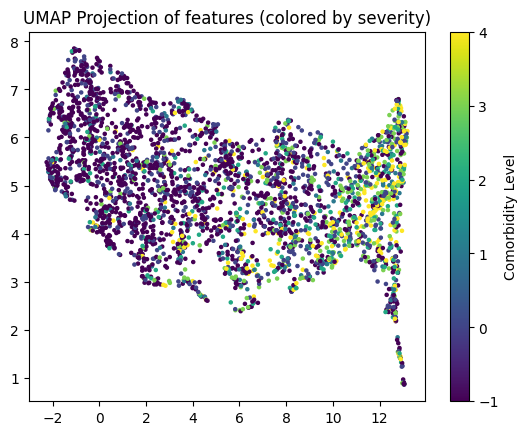

In [42]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=comorbidity_labels, s=5)
plt.colorbar(label='Comorbidity Level')

plt.title('UMAP Projection of features (colored by severity)')